In [ ]:
using Pkg
using SSM
using Random
using Distributions
using LinearAlgebra
using Plots
using ForwardDiff
using Optim

In [ ]:
function toy_PoissonLDS()
    T = 100
    # create a PLDS model
    x0 = [1.0, -1.0]
    p0 = Matrix(Diagonal([0.1, 0.1]))
    A = [cos(0.1) -sin(0.1); sin(0.1) cos(0.1)]
    Q = Matrix(Diagonal([0.1, 0.1]))
    C = [0.5 0.5; 0.5 0.1; 0.9 0.1]
    log_d = log.([0.1, 0.05, 1])
    D = Matrix(Diagonal([0., 0., 0.]))
    b = ones(T, 2) * 0.00

    plds = PoissonLDS(A=A, C=C, Q=Q, D=D, b=b, log_d=log_d, x0=x0, p0=p0, refractory_period=1, obs_dim=3, latent_dim=2)
    # sample data
    x, y = SSM.sample(plds, T, 3)
    return plds, x, y
end

plds, x, y_array = toy_PoissonLDS()
plds.fit_bool = [true, true, true, true, true, true]

b = ones(100, 2) * 0.000;
# plds.A = [cos(0.1) -sin(0.1); sin(0.1) cos(0.1)]
# plds.Q = Matrix(Diagonal([1., 1.]))
# plds.x0 = [0.0, -0.0]
# plds.p0 = Matrix{Float64}([1. 0; 0 1.])
# C = [0.5 0.5; 0.5 0.1; 0.9 0.1]
# log_d = log.([0.1, 0.05, 1])
# D = Matrix(Diagonal([0., 0., 0.]))

In [26]:
@time E_z, E_zz, E_zz_prev, x_smooth, p_smooth = SSM.E_Step(plds, y_array)

  0.019602 seconds (19.25 k allocations: 1.561 MiB)


([0.20709850826515694 1.531768958712076 1.2702420726238886; 1.436795859851566 1.978081765029239 2.1077682807152476; 0.5130204995643982 0.39088717193542477 0.05026593562705378;;; -0.6512292912537166 -0.5938393630198808 0.28089906757518357; -0.0845572541518394 0.010980939034209929 0.5668809327537808; 0.10195655870670703 -0.03269081231298401 -0.03967952740769964], [0.2563835135305298 2.456129829580229 1.757370740957948; 2.1659783260414427 3.9880908587190773 4.518152491777998; 0.4414791344007212 0.369098561774297 0.33432392435921976;;; -0.2103498007486575 -1.0321931995676372 0.16482456761993725; -0.1949817732085529 -0.07220892526579079 1.0697533358025184; -0.03980357589843901 -0.18345030602427714 -0.2944548306384653;;;; -0.21034980074865753 -1.0321931995676372 0.1648245676199372; -0.19498177320855292 -0.07220892526579081 1.0697533358025184; -0.03980357589843904 -0.1834503060242771 -0.2944548306384651;;; 1.0572616240706736 1.1913483645838006 1.1665145882101653; 0.5233853351232802 0.62326241

In [ ]:
H, main, super, sub = SSM.Hessian()

In [24]:

init_mean_est = (E_z[1, 1, :] + E_z[2, 1, :] + E_z[3, 1, :]) / 3

est_1 = E_zz[1, 1, :, :] - init_mean_est * init_mean_est' #- E_z[1, 1, :] * E_z[1, 1, :]'
est_2 = E_zz[2, 1, :, :] - init_mean_est * init_mean_est' #- E_z[2, 1, :] * E_z[2, 1, :]'
est_3 = E_zz[3, 1, :, :] - init_mean_est * init_mean_est' #- E_z[3, 1, :] * E_z[3, 1, :]'

final_est = (est_1 + est_2 + est_3) / 3

2×2 Matrix{Float64}:
  0.246564   -0.0599246
 -0.0599246   0.644223

In [18]:
# optimization based approach
obj = sqrt_p0 -> -SSM.Q_initial_obs(init_mean_est, sqrt_p0, E_z, E_zz)

res = optimize(obj, plds.p0, LBFGS())

 * Status: success

 * Candidate solution
    Final objective value:     2.059375e-01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 5.24e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.54e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.51e-10 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.34e-10 ≰ 0.0e+00
    |g(x)|                 = 3.79e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    8
    f(x) calls:    23
    ∇f(x) calls:   23


In [21]:
res.minimizer * res.minimizer'

2×2 Matrix{Float64}:
  0.246564   -0.0599246
 -0.0599246   0.644223

In [15]:
final_est

2×2 Matrix{Float64}:
  0.18361    -0.0851161
 -0.0851161   0.623929

In [4]:
using Profile
using ProfileView

In [13]:
ProfileView.@profview SSM.fit!(plds, y_array, 1)

Succesfully smoothed at iteration 1
Maximum iterations reached without convergence.


Gtk.GtkWindowLeaf(name="", parent, width-request=-1, height-request=-1, visible=TRUE, sensitive=TRUE, app-paintable=FALSE, can-focus=FALSE, has-focus=FALSE, is-focus=FALSE, focus-on-click=TRUE, can-default=FALSE, has-default=FALSE, receives-default=FALSE, composite-child=FALSE, style, events=0, no-show-all=FALSE, has-tooltip=FALSE, tooltip-markup=NULL, tooltip-text=NULL, window, opacity=1.000000, double-buffered, halign=GTK_ALIGN_FILL, valign=GTK_ALIGN_FILL, margin-left, margin-right, margin-start=0, margin-end=0, margin-top=0, margin-bottom=0, margin=0, hexpand=FALSE, vexpand=FALSE, hexpand-set=FALSE, vexpand-set=FALSE, expand=FALSE, scale-factor=2, border-width=0, resize-mode, child, type=GTK_WINDOW_TOPLEVEL, title="Profile  -  16:35:47", role=NULL, resizable=TRUE, modal=FALSE, window-position=GTK_WIN_POS_NONE, default-width=800, default-height=600, destroy-with-parent=FALSE, hide-titlebar-when-maximized=FALSE, icon, icon-name=NULL, screen, type-hint=GDK_WINDOW_TYPE_HINT_NORMAL, skip

In [25]:
SSM.smooth(plds, y_array)

ArgumentError: ArgumentError: matrix contains Infs or NaNs

In [32]:
plds.A

2×2 Matrix{Float64}:
 0.673648  -0.0403819
 0.307145   0.972538

In [22]:
plds.C

3×2 Matrix{Float64}:
 143.725  112.912
 143.755  112.939
 143.489  112.698

In [15]:
maximum(p_sm)

9.970479765092223

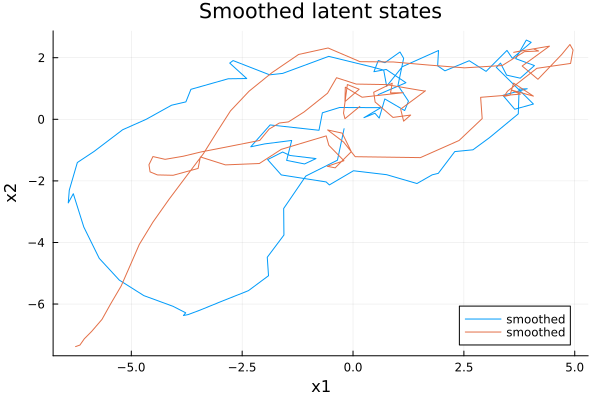

In [13]:
plot(x_sm[1, :, :], x_sm[2, :, :], label="smoothed", xlabel="x1", ylabel="x2", title="Smoothed latent states")

In [7]:
SSM.fit!(plds, y_array, 2)

Succesfully smmothed at iteration 1


SingularException: SingularException(2)

In [7]:
plds.C

3×2 Matrix{Float64}:
 1.20545  0.98404
 1.35706  0.929379
 1.1095   0.245278

In [12]:
# define a function that wraps the loglikelihood function
function likelihood_wrapper(vec_x::Vector{<:Real})
    # Calculate t
    T = Int64(length(vec_x) / plds.latent_dim)
    # convert the vector into the correct from
    x = SSM.interleave_reshape(vec_x, T, plds.latent_dim)
    # Calculate the loglikelihood
    return -SSM.logposterior(x, plds, y)
end

# define a function that wraps the gradient of the loglikelihood function
function gradient!(G::Vector{<:Real}, vec_x::Vector{<:Real})
    # calculate t
    T = Int64(length(vec_x) / plds.latent_dim)
    # convert the vector into the correct form
    x = SSM.interleave_reshape(vec_x, T, plds.latent_dim)
    # Calculate the gradient
    G .= vec(permutedims(-SSM.Gradient(x, plds, y)))
end

# define a function that wraps the hessian of the loglikelihood function
function hessian!(H::Matrix{<:Real}, vec_x::Vector{<:Real})
    # calculate t
    T = Int64(length(vec_x) / plds.latent_dim)
    # convert the vector into the correct form
    x = SSM.interleave_reshape(vec_x, T, plds.latent_dim)
    # Calculate the hessian
    hess, _, _, _ = SSM.Hessian(x, plds, y)
    H .= -hess
end

# init guess
x0 = zeros(200)
y = y_array[3, :, :]

res = optimize(likelihood_wrapper, gradient!, hessian!, x0)

 * Status: success

 * Candidate solution
    Final objective value:     -4.974156e+03

 * Found with
    Algorithm:     Newton's Method

 * Convergence measures
    |x - x'|               = 1.19e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.49e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 7.28e-12 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 1.46e-15 ≰ 0.0e+00
    |g(x)|                 = 5.36e-13 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    7
    f(x) calls:    24
    ∇f(x) calls:   24
    ∇²f(x) calls:  7


In [7]:
x_new = SSM.interleave_reshape(res.minimizer, 100, 2)

100×2 Matrix{Float64}:
 0.818803  -0.505183
 1.0888    -0.869092
 1.00775   -1.67825
 1.32243   -2.1677
 1.6667    -2.26547
 2.28964   -2.61679
 2.77547   -2.41452
 2.52389   -2.22462
 2.77324   -2.00848
 2.54326   -2.05983
 ⋮         
 2.2561    -1.859
 1.2725    -1.46888
 1.32627   -1.07616
 2.26908   -1.28299
 1.76964   -1.22193
 2.20769   -1.44578
 2.68592   -1.19145
 2.72206   -1.67097
 3.18873   -1.6681

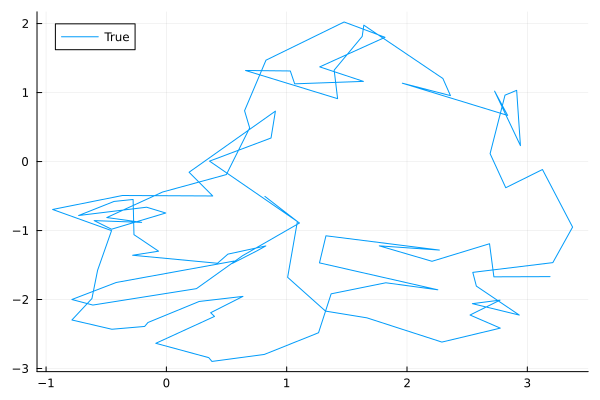

In [15]:
plot(x_new[:, 1], x_new[:, 2], label="True")

In [10]:
grad = SSM.Gradient(x_new, plds, y)

maximum(grad)

8.311129562343922e-13

In [36]:
using CSV
using DataFrames

df = CSV.read("/Users/ryansenne/Downloads/fit_all_4_rest.csv", DataFrame);

In [37]:
function parse_to_matrix(s::String)
    # Remove outer brackets and split by semicolon
    rows = split(strip(s, ['[', ']']), ';')
    
    # Parse each row
    parsed_rows = map(rows) do row
        # Remove brackets from each row and split by comma
        elements = split(strip(row, ['[', ']']), ',')
        
        # Parse each element, handling special cases
        map(elements) do elem
            elem = strip(elem)
            if elem == "-Inf"
                return -Inf
            elseif elem == "Inf" || elem == "+Inf"
                return Inf
            else
                return parse(Float64, elem)
            end
        end
    end
    
    # Convert to matrix
    return reduce(hcat, parsed_rows)'
end
# Apply the parsing function to the 'y' column
df.γ = parse_to_matrix.(df.γ)

ArgumentError: ArgumentError: cannot parse ".346177957733744 0.0 -710.4562785852722 -Inf" as Float64

In [63]:
df = CSV.read("/Users/ryansenne/PyCharmProjects/DCA1_Paper/all_animals_activity_freezing_vector.csv", DataFrame)

df = filter(row -> row[:animal_name] == "astro4", df)

av = reshape(Vector(df[!, :activity_vector]), length(df[!, :activity_vector]), 1)

hmm = SSM.GaussianHMM(av, 2)
baumWelch!(hmm, av)

Computing Baum-Welch... 100%|████████████████████████████| Time: 0:00:04


14-element Vector{Any}:
 -2213.5473980547417
  -915.9549855911815
   205.23889199769616
   711.2313124469748
   741.3036378156872
   743.7558096957705
   744.5880141585463
   744.7241238963218
   744.7429294324645
   744.7454254963877
   744.7457526621024
   744.7457953607749
   744.7458009248927
   744.7458016495822

In [64]:
γ, ξ, α, β = SSM.E_step(hmm, av)

([0.0 -Inf; 0.0 -95.66222005525458; … ; -9.428444524874521 -8.040740203796304e-5; -7.76927470220744 -0.0004226088948371398], [0.0 -Inf; 0.0 -95.66222005525458; … ; -11.302575680451355 -9.59507574101201; -9.496375818540287 -7.965045190790761;;; -95.66222005525458 -Inf; -72.94557991594877 -157.98808211723235; … ; -12.3273026303292 -8.483691897254175e-5; -12.151476373431933 -0.000427891711524353], [-4.417048165552601 -Inf; -5.370644556309378 -95.26116781722914; … ; 737.1811479883636 744.4841754104478; 736.9765269473747 744.7453790406873], [749.1628498151691 743.3911530208343; 750.1164462059259 744.3447494115911; … ; -1.8637908636559288 0.2615458317323476; 0.0 0.0])

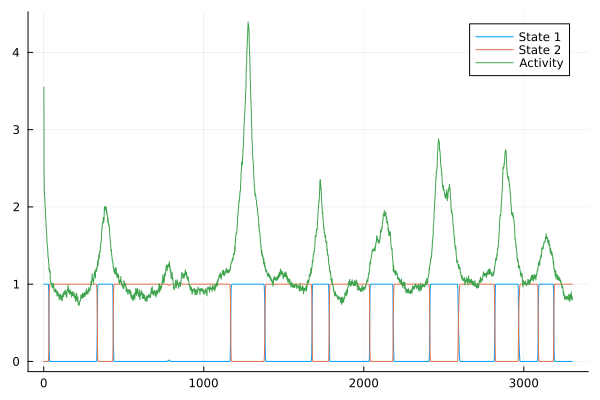

In [65]:
plot(exp.(γ[:, 1]), label="State 1")
plot!(exp.(γ[:, 2]), label="State 2")
plot!(av, label="Activity")